# 버트를 활용한 한국어 개체명 인식 모델

개체명 인식(Named Entity Recognition, NER)은 문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 인식한다.

NER은 버트를 활용한 감정 분류 및 유사도 분류와 맥락은 거의 비슷하나 마지막 히든 벡터값을 사용하는 이전의 접근법과는 다른 점이 있다. 

바로, 문장의 모든 입력 값을 개체명으로 예측하기 위해 모든 은닉 벡터값을 활용한다는 것이다.

### NER 데이터 분석

데이터는 Naver NLP Challenge 2018의 NER 데이터를 활용한다.

학습 데이터 81,000개와 테스트 데이터 9,000개로 나누며 라벨은 총 30개이다.

데이터는 모두 /data_in/KOR/NER 에 위치한다.

### 학습 환경 구성

In [2]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt -O requirements.txt
!pip install -r requirements.txt
!pip install tensorflow==2.2.0

--2021-08-05 14:42:54--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     610  --.-KB/s    in 0s      

2021-08-05 14:42:54 (26.6 MB/s) - ‘requirements.txt’ saved [610/610]

     |████████████████████████████████| 17.3 MB 28 kB/s 
     |████████████████████████████████| 1.4 MB 43.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 769 kB 45.9 MB/s 
     |████████████████████████████████| 1.0 MB 46.8 MB/s 
     |████████████████████████████████| 46.9 MB 43 kB/s 
     |████████████████████████████████| 252 kB 60.3 MB/s 
     |█

In [3]:
!mkdir -p data_in/KOR/NER
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt \
        -O data_in/KOR/NER/label.txt
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv \
        -O data_in/KOR/NER/test.tsv
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/train.tsv \
        -O data_in/KOR/NER/train.tsv

--2021-08-05 14:49:58--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173 [text/plain]
Saving to: ‘data_in/KOR/NER/label.txt’

data_in/KOR/NER/lab 100%[===================>]     173  --.-KB/s    in 0s      

2021-08-05 14:49:58 (5.00 MB/s) - ‘data_in/KOR/NER/label.txt’ saved [173/173]

--2021-08-05 14:49:58--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

### 데이터 불러오기

- train.tsv : 학습 데이터
- test.tsv : 테스트 데이터
- label.txt : 정답 데이터

In [6]:
DATA_IN_PATH = 'drive/MyDrive/data_in/KOR'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")

학습 데이터와 테스트 데이터를 각각 list 형태로 저장하고 두 데이터를 합친다.

한국어 개체명 인식 데이터를 pandas로 불러올 경우, 따옴표 등의 이슈로 인해 전체 데이터가 감소한다.

따라서 일반적인 데이터 불러오기 방법을 진행한 후 pandas에 DataFrame으로 변환한다.

한국어 개체명 데이터는 '탭'을 기준으로 나뉘기 때문에 for문을 사용해 각 문장은 sentences에, 라벨은 labels에 저장한다.

학습 데이터와 테스트 데이터를 ner_sentences, ner_labels로 각각 합친 후 pd.DataFrame을 활용하기 위해 ner_dict 구조로 변환한다.

In [7]:
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels
    
train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_sentences = train_sentences + test_sentences
ner_labels = train_labels + test_labels

ner_dict = {"sentence": ner_sentences, "label": ner_labels}
ner_df = pd.DataFrame(ner_dict)

In [8]:
print('전체 ner_data 개수: {}'.format(len(ner_df)))
ner_df.head(5)

전체 ner_data 개수: 90000


,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


### NER 데이터 라벨 설명

개체명 인식은 BIO 태깅을 사용하여 모델이 학습할 때 문장에서 개체명으로서 의미 있는 토큰들의 위치를 인식하게 도와준다.

- B(begin) : 개체명의 시작
- I(Inside) : 개체명의 내부
- O(Outside) : 개체명이 아닌 부분

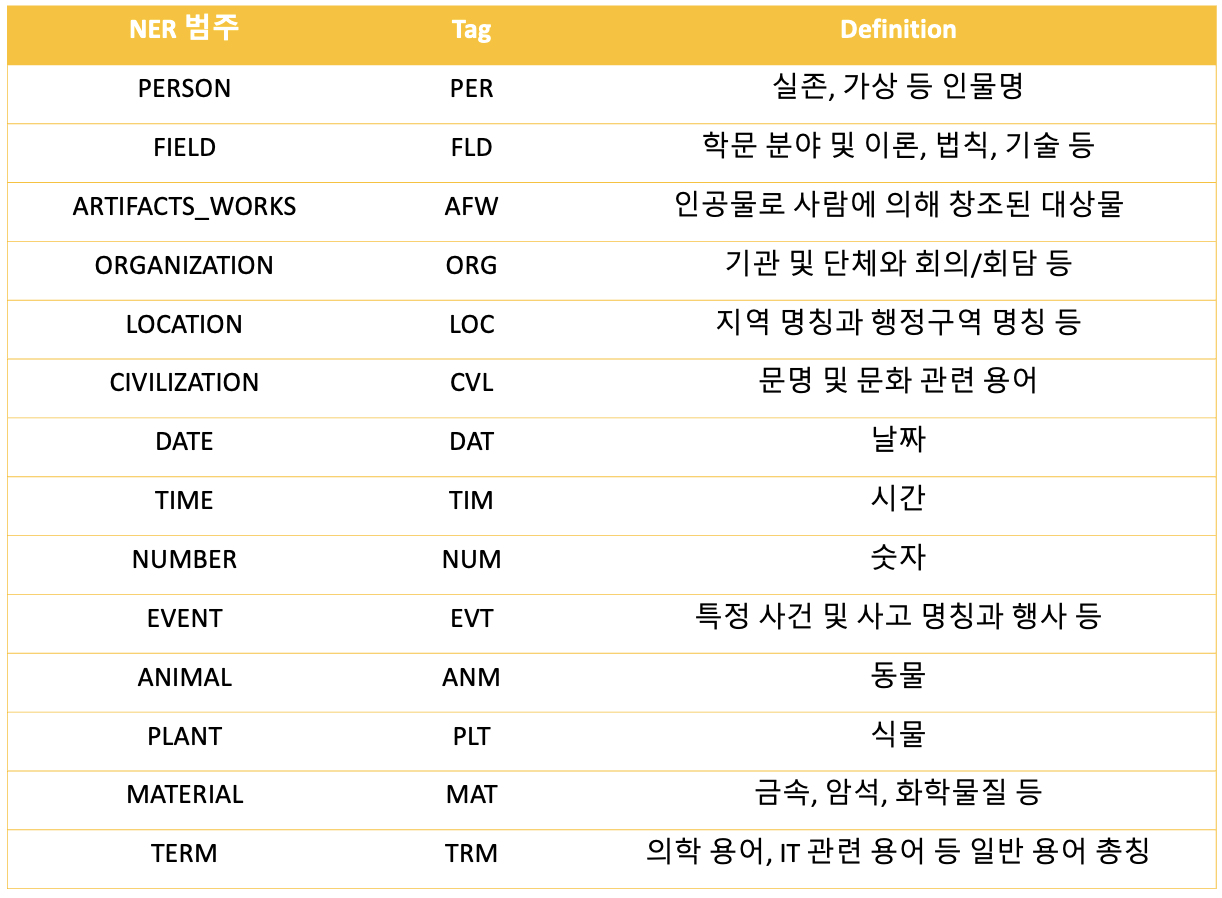

### 한국어 개체명 텍스트 분석

In [10]:
train_set = pd.Series(ner_df["sentence"].tolist())
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

유일한 총 문장 수 : 88703
반복해서 나타나는 문장의 수: 288


Text(0, 0.5, 'Number of sentence')

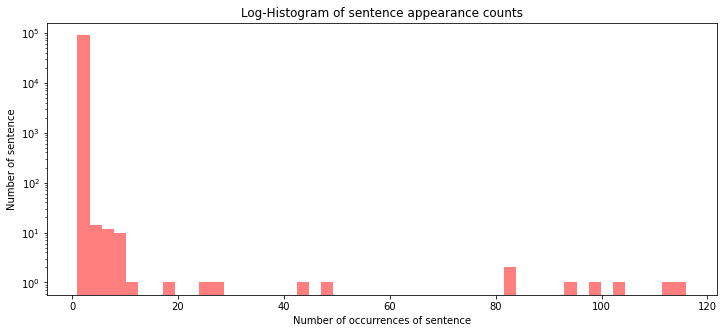

In [11]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [12]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 116
중복 최소 개수: 1
중복 평균 개수: 1.01
중복 표준편차: 0.92
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f401a312d90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f401a320c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f401a30f250>],
 'means': [<matplotlib.lines.Line2D at 0x7f401a324cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f401a324790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f401a360090>,
  <matplotlib.lines.Line2D at 0x7f401a320750>]}

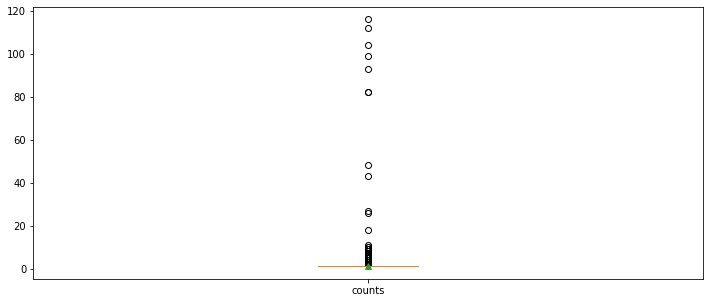

In [13]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

In [14]:
train_length = train_set.apply(len)

In [15]:
train_set[0]

'금석객잔 여러분, 감사드립니다 .'

In [16]:
train_length

0         18
1         39
2         60
3        125
4         18
        ... 
89995     19
89996     62
89997     22
89998     54
89999     50
Length: 90000, dtype: int64

In [17]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 1162
문장 길이 평균 값: 50.90
문장 길이 표준편차: 34.15
문장 길이 중간 값: 43.0
문장 길이 제 1 사분위: 29.0
문장 길이 제 3 사분위: 63.0


Text(0, 0.5, 'Probability')

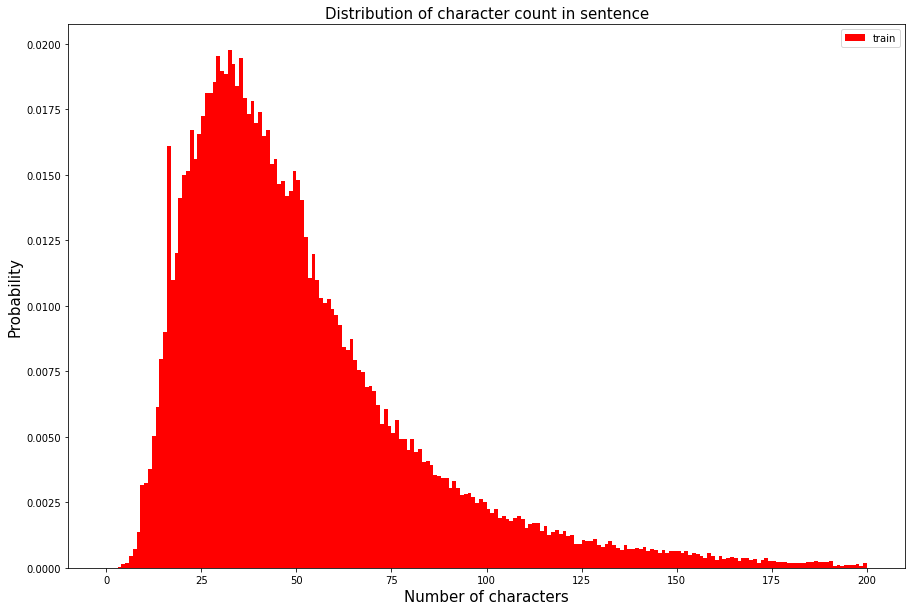

In [18]:
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Distribution of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

{'boxes': [<matplotlib.lines.Line2D at 0x7f4019c0cd10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f4019b9e890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4019ba5e10>],
 'means': [<matplotlib.lines.Line2D at 0x7f4019ba58d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4019ba5390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4019b9cdd0>,
  <matplotlib.lines.Line2D at 0x7f4019b9e350>]}

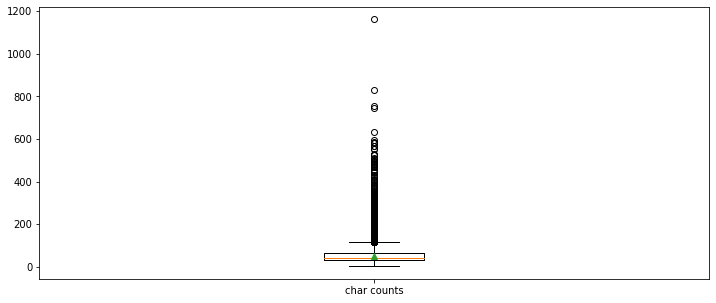

In [19]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

In [21]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

문장 단어 개수 최대 값: 175
문장 단어 개수 평균 값: 11.82
문장 단어 개수 표준편차: 7.03
문장 단어 개수 중간 값: 10.0
문장 단어 개수 제 1 사분위: 7.0
문장 단어 개수 제 3 사분위: 15.0
문장 단어 개수 99 퍼센트: 35.0


### NER 문장별 단어 단위 히스토그램 분포

Text(0, 0.5, 'Probability')

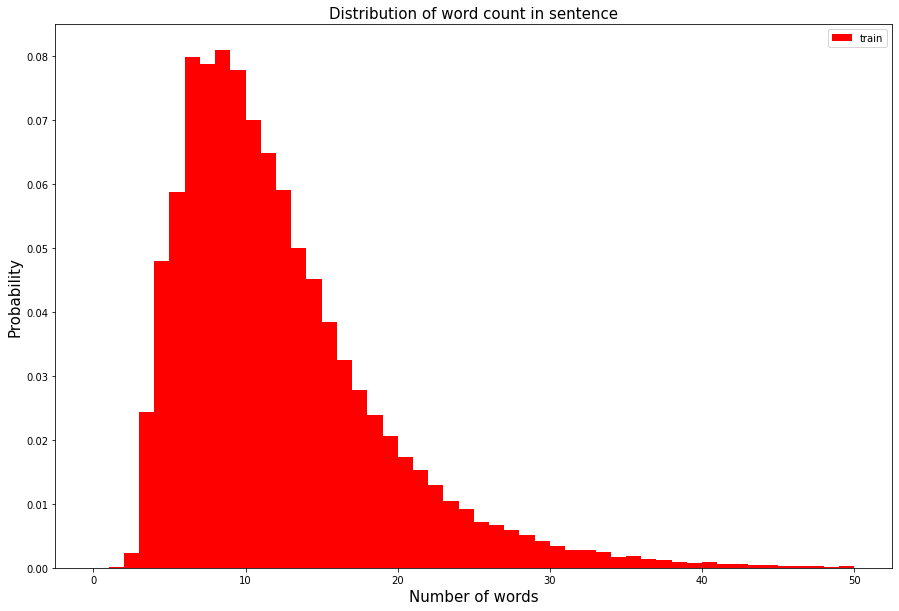

In [22]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Distribution of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### NER 단어 단위 박스플롯

{'boxes': [<matplotlib.lines.Line2D at 0x7f4019aa4690>],
 'caps': [<matplotlib.lines.Line2D at 0x7f4019a1e490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4019a269d0>],
 'means': [<matplotlib.lines.Line2D at 0x7f4019a264d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4019a1ef50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4019a169d0>,
  <matplotlib.lines.Line2D at 0x7f4019a16f10>]}

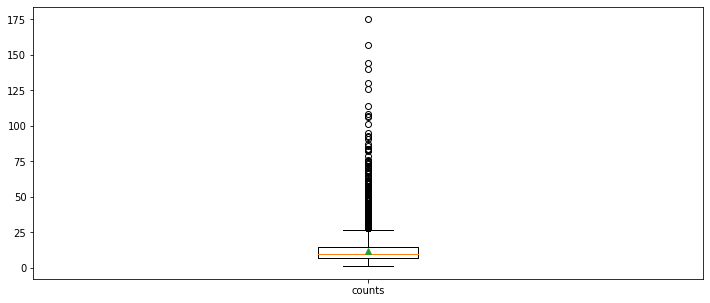

In [23]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

In [24]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개

In [25]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개
                  
print('물음표가있는 문장: {:.2f}%'.format(qmarks * 100))
print('수학 태그가있는 문장: {:.2f}%'.format(math * 100))
print('마침표를 포함한 문장: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 문장: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 문장: {:.2f}%'.format(capitals * 100))
print('숫자가있는 문장: {:.2f}%'.format(numbers * 100))

물음표가있는 문장: 2.24%
수학 태그가있는 문장: 0.00%
마침표를 포함한 문장: 84.92%
첫 글자가 대문자 인 문장: 2.87%
대문자가있는 문장: 16.65%
숫자가있는 문장: 41.61%


## BERT Tokenizer를 활용한 문장 분석

In [26]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [27]:
train_bert_token_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

### NER 문장별 버트 토큰 개수 분포

Text(0, 0.5, 'Probability')

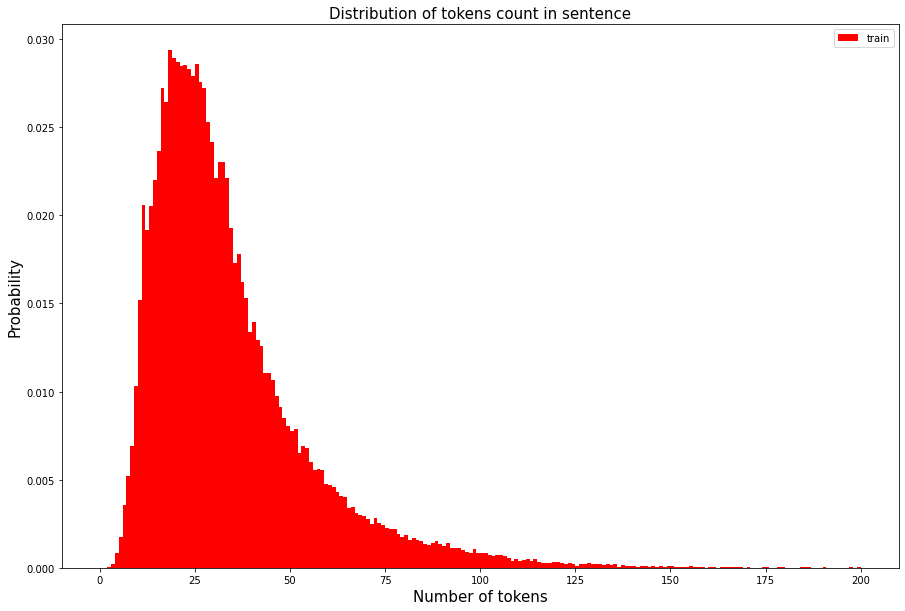

In [28]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=200, range=[0, 200], facecolor='r', density=True, label='train')
plt.title('Distribution of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [29]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 850
문장 tokens 개수 평균 값: 33.62
문장 tokens 개수 표준편차: 22.76
문장 tokens 개수 중간 값: 28.0
문장 tokens 개수 제 1 사분위: 19.0
문장 tokens 개수 제 3 사분위: 41.0
문장 tokens 개수 99 퍼센트: 111.0


### NER 버트 토큰 단위 박스플롯

{'boxes': [<matplotlib.lines.Line2D at 0x7f4018c6b590>],
 'caps': [<matplotlib.lines.Line2D at 0x7f4018bfd5d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4018becb10>],
 'means': [<matplotlib.lines.Line2D at 0x7f4018bec610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4018bec0d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4018bddb10>,
  <matplotlib.lines.Line2D at 0x7f4018bfd090>]}

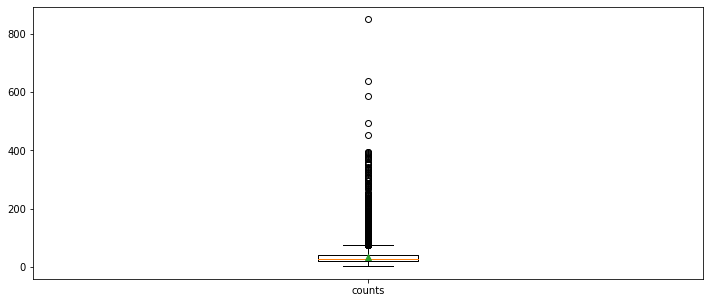

In [30]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
             labels=['counts'],
             showmeans=True)